## plot the DESI line confusions

In [103]:
import os, sys
import random
import fitsio
import numpy as np
from astropy.table import Table,join,unique,vstack
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap
from matplotlib import ticker
import random

from desitarget.targetmask import desi_mask, bgs_mask
from desitarget.sv3.sv3_targetmask import desi_mask as sv3_desi_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask
from desitarget.targetmask import zwarn_mask as zmtl_zwarn_mask

sys.path.append('/global/homes/s/shengyu/desi_y3_redshift_errors/main/')
from helper import REDSHIFT_OVERALL, COLOR_OVERALL
from helper import REDSHIFT_VSMEAR, REDSHIFT_LSS_VSMEAR, REDSHIFT_CUBICBOX, EDGES, COLOR_TRACERS, GET_RECON_BIAS
%load_ext autoreload
%autoreload 2

c = 299792.458

REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
def generate_dz(tracer, zmin, zmax):
    d = Table.read(f'{REPEAT_DIR}/{tracer}repeats.fits', hdu=1)
    sel      = np.full(len(d),True)
    sel = np.isfinite(d['Z1']) & np.isfinite(d['Z2'])
    selz = ((zmin<d["Z1"])&(d["Z1"]<zmax))
    d_zbin = d[sel & selz]
    return d_zbin

In [57]:
tracer = 'QSO'
(zmin, zmax) = REDSHIFT_OVERALL[tracer]
d = generate_dz(tracer, zmin, zmax)
d

TARGETID,Z1,Z2
int64,float64,float64
39627339935517046,1.562111072942146,1.5621377896741206
39627339939711018,1.6190576470151152,1.6254695323444335
39627340275255870,1.908172028661586,1.8717108538788907
39627340304616185,0.9132178153200913,0.9133023613899471
39627340304620362,2.085308579627775,2.126431366503405
39627340304620362,2.085308579627775,2.087520394184239
39627340308809958,2.0069874372445744,2.0115207691266135
39627340409475816,1.2288127471240715,1.2285537896465724
39627340417864619,1.7182248381961127,1.7215682777247514


In [127]:
line_set = [1215.67, 1549, 1908, 2800, 3727, 3868, 4101, 4340, 4861, 4958, 5007, 6562]
name_set = [r'Ly$\alpha$', 'C[IV]', 'C[III]', 'Mg[II]', 'O[II]', 'Ne[III]',
            r'H$\delta$', r'H$\gamma$', r'H$\beta$', 'O[III]1', 'O[III]2', r'H$\alpha$']

def plot_confusion_lines(ax, focus = 'Mg[II]', remove = None):
    alpha = 0.8
    if focus not in name_set:
        raise ValueError(f"Focus line '{focus}' not found in names list.")
    if remove != None:
        lines, names = zip(*[(l, n) for l, n in zip(line_set, name_set) if n not in remove])
    else:
        lines, names = line_set, name_set
    # Loop over all possible pairs
    x = np.linspace(-0.01, 4.0, 2)
    if focus != None:
        focus_idx = names.index(focus)
        if focus == 'C[IV]':
            colormap = get_cmap('viridis')
        else:
            colormap = get_cmap('plasma')
        colors = [tuple(c) for c in colormap(np.linspace(0, 1, len(lines)+1))] 
        for j, (lam, name) in enumerate(zip(lines, names)):
            if name == focus:
                continue
            # case 1: focus line mistaken for others
            y1 = lines[focus_idx]/lam * (1+x) - 1
            ax.plot(x, y1, '--', color=colors[j], lw=0.8, label=f'{focus} → {name}', alpha=alpha)
            # case 2: others mistaken for focus
            y2 = lam/lines[focus_idx] * (1+x) - 1
            ax.plot(x, y2, '--', color=colors[j], lw=0.8, alpha=alpha)
    else:
        colors = plt.cm.tab20(np.linspace(0, 1, len(lines) * (len(lines)-1)))
        for k, (i, j) in enumerate([(i, j) for i in range(len(lines)) for j in range(len(lines)) if i != j]):
            true, false = lines[i], lines[j]
            y = true/false * (1 + np.linspace(-0.01, 3.0, 2)) - 1
            ax.plot(x, y, ':', color=colors[k], lw=0.3, alpha=alpha,
                    label=f'{names[i]} → {names[j]}')


def identify_line_confusions(d, focus, remove= None, tol=0.001):
    if focus not in name_set:
        raise ValueError(f"Focus line '{focus}' not found in names list.")
    if remove != None:
        lines, names = zip(*[(l, n) for l, n in zip(line_set, name_set) if n not in remove])
    else:
        lines, names = line_set, name_set
    focus_idx = names.index(focus)
    lam_focus = lines[focus_idx]
    # prepare dictionary to store results
    confusion_dict = {}
    for i, (lam, name) in enumerate(zip(lines, names)):
        if name == focus or name in remove:
            continue
        key = f"{focus} → {name}"
        confusion_dict[key] = []
        for row in d:
            Z0 = row['Z_0']
            Z1 = row['Z_1']
            # check line confusion
            Z_cata1 = lam_focus / lam * (1 + Z0) - 1
            Z_cata2 = lam / lam_focus * (1 + Z0) - 1
            if abs(Z1 - Z_cata1) < tol or abs(Z1 - Z_cata2) < tol:
                confusion_dict[key].append({
                    'TARGETID': row['TARGETID'],
                    'Z_0': row['Z_0'],
                    'Z_1': row['Z_1'],
                    'TILEID_0': row['TILEID_0'],
                    'TILEID_1': row['TILEID_1']
                })
    return confusion_dict

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_1495137/1040143088.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('plasma')
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_1495137/1040143088.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplo

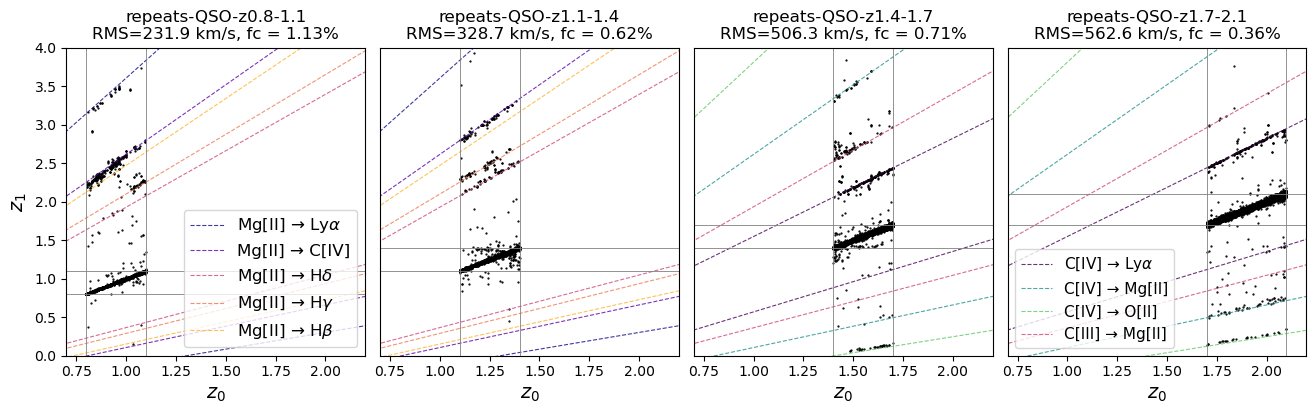

In [128]:
SAVE_ID = False

fig = plt.figure(figsize = (16, 4))
gs = gridspec.GridSpec(1, 4, wspace=0.05, hspace=0.10,)
cthr = 10000
zmins = [0.8,1.1,1.4,1.7]
zmaxs = [1.1,1.4,1.7,2.1]
all_lcs = {}

for zind,(zmin,zmax) in enumerate(zip(zmins,zmaxs)):
    d = generate_dz(tracer, zmin, zmax)
    dv = (d['Z2']-d['Z1'])/(1+d['Z1'])*c
    dv_smear = dv[abs(dv) < cthr]
    median_dv = np.median(abs(dv))
    RMS = np.sqrt(np.mean(dv_smear**2))
    fc= np.mean(abs(dv) >= cthr)*100
    # plot the distribution
    ax = fig.add_subplot(gs[zind]) 
    ax.plot(d["Z1"],d["Z2"],'.',markersize=1.2,color='k',alpha=1.0)
    if zind in [0,1]:
        plot_confusion_lines(ax, focus = 'Mg[II]', remove = ['Ne[III]','O[II]','O[III]1', 'O[III]2', 'C[III]', r'H$\alpha$'])
        if zind == 0:
            # ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12, ncol=3,)
            ax.legend(loc=4, fontsize=12, ncol=1,)
            ax.set_ylabel('$z_1$', fontsize=14)
    elif zind in [2,3]:
        plot_confusion_lines(ax, focus = 'C[IV]', remove = ['Ne[III]', r'H$\alpha$','O[III]1', 'O[III]2', r'H$\delta$', r'H$\gamma$', r'H$\beta$','C[III]'])
        plot_confusion_lines(ax, focus = 'C[III]', remove = ['Ne[III]', r'H$\alpha$','O[III]1', 'O[III]2', r'H$\delta$', r'H$\gamma$', r'H$\beta$', 'C[IV]', 'O[II]',r'Ly$\alpha$'])
        if zind == 3:
            # ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12, ncol=1,)
            ax.legend(loc=3, fontsize=11, ncol=1,)
    for value in [zmin, zmax]:
        ax.axvline(value, color='grey', lw=0.6, ls='-')
        ax.axhline(value, color='grey', lw=0.6, ls='-')
    ax.set_xlim(0.8-0.1, 2.1+0.1)
    ax.set_ylim(0,4)
    ax.set_xlabel('$z_0$', fontsize=14)
    if zind>0:
        ax.set_yticklabels([])
        ax.tick_params(axis='y', which='both', left=False, right=False, labelbottom=False)
    # ax.set_ylabel('$z_1$', fontsize=14)
    ax.set_title(
        f'repeats-QSO-z{zmin}-{zmax}\n'
        f'RMS={np.sqrt(np.mean(dv_smear ** 2)):.1f} km/s, fc = {fc:.2f}%'
    )
    #save the id with catastrohics    
    if SAVE_ID == True:
        if zind in [0,1]:
            lcs = identify_line_confusions(d, focus = 'Mg[II]', remove = ['Ne[III]','O[II]','O[III]1', 'O[III]2', r'Ly$\alpha$', r'H$\alpha$'], tol= 0.001)
        elif zind in [2,3]:
            lcs = identify_line_confusions(d, focus = 'C[IV]', remove = ['Ne[III]', r'H$\alpha$','O[III]1', 'O[III]2', r'H$\delta$', r'H$\gamma$', r'H$\beta$','C[III]'], tol= 0.001)
        for key, val in lcs.items():
            if key in all_lcs:
                all_lcs[key].extend(val)  # append new values
            else:
                all_lcs[key] = val        # create new list
# check if they are all good redshifts

/tmp/ipykernel_1495137/206501413.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('plasma')
/tmp/ipykernel_1495137/206501413.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('viridis')


Text(0.5, 1.0, 'repeats-QSO-z0.8-2.1\n')

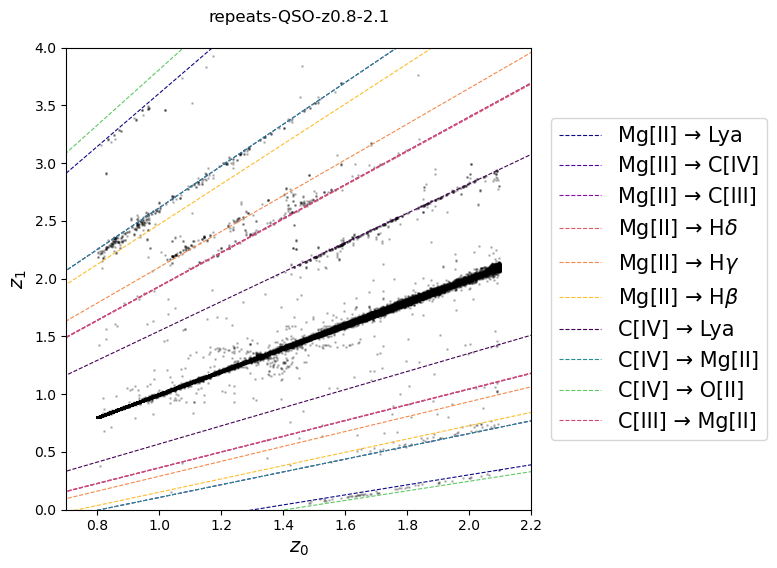

In [113]:
fig = plt.figure(figsize = (6, 6))
dvcatas = 10000
sel      = np.full(len(d),True)
# selcata = abs(d["DV"]) < dvcatas
zmin = 0.8
zmax = 2.1

d = generate_dz(tracer, zmin, zmax)
plt.plot(d["Z1"],d["Z2"],'.',markersize=2,color='k',alpha=0.2)
plot_confusion_lines(plt, focus = 'Mg[II]', remove = ['Ne[III]','O[II]','O[III]1', 'O[III]2', r'H$\alpha$'])
plot_confusion_lines(plt, focus = 'C[IV]', remove = ['Ne[III]', r'H$\alpha$','O[III]1', 'O[III]2', r'H$\delta$', r'H$\gamma$', r'H$\beta$','C[III]'])
plot_confusion_lines(plt, focus = 'C[III]', remove = ['Ne[III]', r'H$\alpha$','O[III]1', 'O[III]2', r'H$\delta$', r'H$\gamma$', r'H$\beta$', 'C[IV]', 'O[II]','Lya'])
# for value in [1.4]:
    # plt.axhline(value, color='red', lw=0.6, ls='--', label = r'potential sky residual $z\approx1.4$')
    # plt.axvline(value, color='red', lw=0.6, ls='--')
# for value in [zmin, zmax]:
    # plt.axvline(value, color='grey', lw=0.6, ls='-')
    # plt.axhline(value, color='grey', lw=0.6, ls='-')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=15, ncol=1,)
plt.xlim(0.8-0.1, 2.1+0.1)
plt.ylim(0,4)
plt.xlabel('$z_0$', fontsize=14)
plt.ylabel('$z_1$', fontsize=14)
plt.title(
    f'repeats-QSO-z{zmin}-{zmax}\n'
    # f'RMS(dv<10000)={np.sqrt(np.mean(dv_smear ** 2)):.1f} km/s, fc = {fc*100:.2f}%'
)

In [ ]:
data = np.load('QSO_line_confusions.npy', allow_pickle=True).item()
confusions = data['Mg[II] → C[IV]']
one_sample = random.choice(confusions)
# one_sample = confusions[12]
print(one_sample)
id = one_sample['TARGETID']
d[d['TARGETID']==id]

{'TARGETID': 39627363352317106, 'Z_0': 3.200335587279043, 'Z_1': 1.3237345831783631, 'TILEID_0': 5562, 'TILEID_1': 2424}


TARGETID,TARGET_RA,TARGET_DEC,PHOTSYS,DESI_TARGET,BGS_TARGET,SURVEY_0,TILEID_0,LASTNIGHT_0,PETAL_LOC_0,FIBER_0,COADD_FIBERSTATUS_0,TSNR2_BGS_0,TSNR2_LRG_0,TSNR2_ELG_0,TSNR2_QSO_0,TSNR2_LYA_0,Z_0,ZERR_0,ZWARN_0,DELTACHI2_0,OII_FLUX_0,OII_FLUX_IVAR_0,Z_NEW_0,ZERR_NEW_0,IS_QSO_QN_NEW_RR_0,ZMTL_ZWARN_0,ZMTL_Z_QN_0,ZMTL_Z_QN_CONF_0,ZMTL_IS_QSO_QN_0,GOOD_BGS_0,GOOD_LRG_0,GOOD_ELG_0,GOOD_QSO_0,SURVEY_1,TILEID_1,LASTNIGHT_1,PETAL_LOC_1,FIBER_1,COADD_FIBERSTATUS_1,TSNR2_BGS_1,TSNR2_LRG_1,TSNR2_ELG_1,TSNR2_QSO_1,TSNR2_LYA_1,Z_1,ZERR_1,ZWARN_1,DELTACHI2_1,OII_FLUX_1,OII_FLUX_IVAR_1,Z_NEW_1,ZERR_NEW_1,IS_QSO_QN_NEW_RR_1,ZMTL_ZWARN_1,ZMTL_Z_QN_1,ZMTL_Z_QN_CONF_1,ZMTL_IS_QSO_QN_1,GOOD_BGS_1,GOOD_LRG_1,GOOD_ELG_1,GOOD_QSO_1,DV_Redrock,DV_NEW,DV
int64,float64,float64,bytes1,int64,int64,bytes4,int64,int64,int16,int32,int32,float32,float32,float32,float32,float32,float64,float64,int64,float64,float32,float32,float64,float32,bool,int64,float64,float64,int16,bool,bool,bool,bool,bytes4,int64,int64,int16,int32,int32,float32,float32,float32,float32,float32,float64,float64,int64,float64,float32,float32,float64,float32,bool,int64,float64,float64,int16,bool,bool,bool,bool,float64,float64,float64
39627363352317106,55.6487453380297,-17.810383857223822,S,262148,0,main,10244,20231019,8,4115,0,7893.746,96.82045,146.71275,35.976295,76.81589,3.202059473941264,0.0004551032557606953,0,568.8015433712862,--,--,--,--,False,0,3.219064987169358,0.9999999964641662,1,True,False,False,True,main,2424,20230902,9,4855,0,7711.078,87.98096,150.78223,35.64442,52.864285,1.3237345831783631,6.999497244286754e-05,0,18.959942631423473,-0.8981591,0.7555639,3.2002418740159175,0.00042351426,True,0,3.2430835045609,0.911873511347662,1,False,True,False,True,-134007.53592767037,--,-134007.53592767037
39627363352317106,55.6487453380297,-17.810383857223822,S,262148,0,main,5562,20231014,2,1230,0,6332.2803,74.36778,106.28519,27.24759,80.94521,3.200335587279043,0.0005341384582840862,0,606.4355046153069,--,--,--,--,False,0,3.2125151108484724,0.9999998217963493,1,True,False,False,True,main,2424,20230902,9,4855,0,7711.078,87.98096,150.78223,35.64442,52.864285,1.3237345831783631,6.999497244286754e-05,0,18.959942631423473,-0.8981591,0.7555639,3.2002418740159175,0.00042351426,True,0,3.2430835045609,0.911873511347662,1,False,True,False,True,-133939.49507473866,--,-133939.49507473866
39627363352317106,55.6487453380297,-17.810383857223822,S,262148,0,main,5562,20231014,2,1230,0,6332.2803,74.36778,106.28519,27.24759,80.94521,3.200335587279043,0.0005341384582840862,0,606.4355046153069,--,--,--,--,False,0,3.2125151108484724,0.9999998217963493,1,True,False,False,True,main,10244,20231019,8,4115,0,7893.746,96.82045,146.71275,35.976295,76.81589,3.202059473941264,0.0004551032557606953,0,568.8015433712862,--,--,--,--,False,0,3.219064987169358,0.9999999964641662,1,True,False,False,True,123.03974504935634,--,123.03974504935634


In [ ]:
# VI the spectra: QSO confusion
from prospect import viewer, utilities
datadir = os.environ['DESI_SPECTRO_REDUX']+f'/kibo/tiles/cumulative' 
targets = [39627363352317106] # targetID
tiles   = [5562, 2424] # TILEID_0 and TILEID_1
print(targets, tiles)
subset_db = utilities.create_subsetdb(datadir, dirtree_type='cumulative', tiles=tiles)
target_db = utilities.create_targetdb(datadir, subset_db, dirtree_type='cumulative')
### Prepare adapted set of Spectra + catalogs
spectra, zcat, rrcat = utilities.load_spectra_zcat_from_targets(targets, datadir, target_db, dirtree_type='cumulative', with_redrock_details=True)
# Run this cell to have the VI tool !
viewer.plotspectra(spectra, zcatalog=zcat, redrock_cat=rrcat, notebook=True,
                   title='My TARGETIDs', top_metadata=['TARGETID', 'TILEID', 'FIBER'])
# kibo vs loa 
# different directory between data

[39627580709540879] [7952, 9509]


RuntimeError: Some tile[s]/nights[s] were not found in directory tree.

In [ ]:
zip(*one_sample)

### -----------------------------------------------------------------------------------------------------------------------------
### -----------------------------------------------------------------------------------------------------------------------------


In [ ]:
from desitarget.targetmask import desi_mask, bgs_mask
from desitarget.targetmask import zwarn_mask as zmtl_zwarn_mask

tracer = 'QSO'
# catas_limit  = 3000
catas_limit  = 10000
survey = 'DR2'

if survey == 'DR2':
    RMSs = []
    fcs = []
    number = []
    # zmins = np.arange(0.55, 4.1, 0.1)
    # zmaxs = zmins+0.1
    zmins = [0.8, 1.1, 1.4, 1.7]
    zmaxs = [1.1, 1.4, 1.7, 2.1]
    for zind,(zmin,zmax) in enumerate(zip(zmins,zmaxs)):
    # print(zind, (zmin,zmax))
        repeatdir= f'/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/main-repeats-kibo-dark-pairs_QSO.fits'
        d        = Table(fitsio.read(repeatdir))
        d        = d[~np.isnan(d['DV'])]
        # cut on redshift range 
        sel      = np.full(len(d),True)
        selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
        selcata = abs(d["DV"]) < catas_limit
        dv_zbin = d['DV'][sel & selz]
        dv_smear = d['DV'][sel & selz & selcata]
        fc = 1-len(dv_smear)/len(dv_zbin)
        RMS = np.sqrt(np.mean(dv_smear ** 2))
        print(f"{len(dv_zbin)}, {RMS:.1f}, {fc*100:.2f}%")
    # save = np.column_stack((np.array(zmins+zmaxs)/2, RMS, number))
    # np.savetxt(f'../results/DESI_{survey}_QSO_redshift_error_points.txt', save, 
    #         header="redshift, RMS of vsmear(km/s), number of repeat observation pairs", delimiter=", ", fmt="%.2f, %.8f, %i")
if survey == 'EDR':
    RMS = []
    number = []
    # zmins = np.arange(0.75, 3.55, 0.1)
    zmins = np.arange(0.75, 2.15, 0.1)
    zmaxs = zmins+0.1
    for zind,(zmin,zmax) in enumerate(zip(zmins,zmaxs)):
        repeatdir= f'/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR/QSO_dv.fits'
        d        = Table.read(repeatdir)
        d        = d[~np.isnan(d['DV'])]
        sel      = np.full(len(d),True)
        selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
        selcata = abs(d["DV"]) < dvcatas
        dv = d['DV'][sel & selz & selcata]
        RMS.append(np.sqrt(np.mean(dv ** 2)))
        number.append(len(dv))
    zmean = np.array(zmins+zmaxs)/2
    table = np.column_stack((zmean, number, RMS)).T
    # save = np.column_stack((np.array(zmins+zmaxs)/2, RMS, number))
    # np.savetxt(f'../results/DESI_{survey}_QSO_redshift_error_points.txt', save, 
    #         header="redshift, RMS of vsmear(km/s), number of repeat observation pairs", delimiter=", ", fmt="%.2f, %.8f, %i")

35141, 252.9, 3.08%
53478, 379.8, 1.46%
68460, 571.4, 1.78%
121444, 614.7, 0.89%


## APPENDIX

In [ ]:
#redshift errors distribution for QSO
repeatdir= f'/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/main-repeats-kibo-dark-pairs_QSO.fits'

tracer = 'QSO'
catas_limit  = 10000
num_zbins = len(REDSHIFT_VSMEAR[tracer])

NUM_bins = 80
fig = plt.figure(figsize = (8, 5))
# gs = gridspec.GridSpec(1, 1, wspace=0.22)
colormap = get_cmap('plasma')
colors = [tuple(c) for c in colormap(np.linspace(0, 1, num_zbins+2))] 

for zind, (zmin, zmax) in enumerate(REDSHIFT_VSMEAR['QSO']):
    #selection
    sel      = np.full(len(d),True)
    selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
    selcata = abs(d["DV"]) < catas_limit
    #zbin
    dv_zbin = d['DV'][sel & selz]
    logdv_zbin = np.log10(abs(dv_zbin))
    median_dv = np.median(logdv_zbin)
    dv_smear = d['DV'][sel & selz & selcata]
    fc = 1-len(dv_smear)/len(dv_zbin)
    RMS = np.sqrt(np.mean(dv_smear ** 2))
    # print(f"{len(dv_zbin)}, {RMS:.1f}, {fc*100:.2f}%")
    plt.hist(logdv_zbin, histtype='step', bins=np.linspace(-2, 6, NUM_bins),
            color= colors[zind+1], label = f'dv-QSO z{zmin}-{zmax}, median={10**median_dv:.2f} km/s, vsmear RMS={np.sqrt(np.mean(dv_smear ** 2)):.1f} km/s, fc = {fc*100:.2f}%', lw = 1.5)
    plt.axvline(x=(median_dv), color=colors[zind+1], linestyle='--', linewidth=1.2)
plt.axvline(x=4 if tracer == 'QSO' else 3, color='black', linestyle='--', linewidth=2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01), fontsize=11)
plt.yscale('log')
plt.ylim([10**(0.), 10**(5.2)])
plt.xlim([-2, 6])
# plt.xlabel(r'$\log_{10}(|\Delta v_{\mathrm{error}}|)$ (km/s)')
plt.xlabel(r'$|\Delta v_{\mathrm{error}}|$ (km/s)')
ax = plt.gca() 
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: fr"$10^{{{int(x)}}}$"))
plt.ylabel('Number Counts')
plt.grid(True)

In [ ]:
SAVE_ID = False


fig = plt.figure(figsize = (13, 12))
gs = gridspec.GridSpec(2, 2, wspace=0.25, hspace=0.25)

dvcatas = 10000
selcata = abs(d["DV"]) < dvcatas
zrange = [0.0, 3.5]
zmins = [0.8,1.1,1.4,1.7]
zmaxs = [1.1,1.4,1.7,2.1]
all_lcs = {}

# AR zmtl_zwarn_mask nodata + bad
nodata0 = (d["ZMTL_ZWARN_0"] & zmtl_zwarn_mask["NODATA"]) > 0
nodata1 = (d["ZMTL_ZWARN_1"] & zmtl_zwarn_mask["NODATA"]) > 0
badqa0 = (d["ZMTL_ZWARN_0"] & zmtl_zwarn_mask.mask("BAD_SPECQA|BAD_PETALQA")) > 0
badqa1 = (d["ZMTL_ZWARN_1"] & zmtl_zwarn_mask.mask("BAD_SPECQA|BAD_PETALQA")) > 0

for zind,(zmin,zmax) in enumerate(zip(zmins,zmaxs)):
    selz = ((zmin<d["Z_0"])&(d["Z_0"]<zmax))|((zmin<d["Z_1"])&(d["Z_1"]<zmax))
    sel &= (d["COADD_FIBERSTATUS_0"] == 0) & (d["COADD_FIBERSTATUS_1"] == 0)
    sel &= (~nodata0) & (~nodata1)
    sel &= (~badqa0) & (~badqa1)
    d_sel = d[sel & selz]
    #redshift errors configuration
    dv_zbin = d['DV'][sel & selz]
    dv_smear = d['DV'][sel & selz & (abs(d["DV"]) < dvcatas)]
    fc = 1-len(dv_smear)/len(dv_zbin)
    RMS = np.sqrt(np.mean(dv_smear ** 2))
    # plot the distribution
    ax = fig.add_subplot(gs[zind]) 
    ax.plot(d_sel["Z_0"],d_sel["Z_1"],'.',markersize=1.2,color='k',alpha=1.0)
    if zind in [0,1]:
        plot_confusion_lines(ax, focus = 'Mg[II]', remove = ['Ne[III]','O[II]','O[III]1', 'O[III]2', 'C[III]', r'H$\alpha$'])
        if zind == 1:
            ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=15, ncol=1,)
    elif zind in [2,3]:
        plot_confusion_lines(ax, focus = 'C[IV]', remove = ['Ne[III]', r'H$\alpha$','O[III]1', 'O[III]2', r'H$\delta$', r'H$\gamma$', r'H$\beta$','C[III]'])
        plot_confusion_lines(ax, focus = 'C[III]', remove = ['Ne[III]', r'H$\alpha$','O[III]1', 'O[III]2', r'H$\delta$', r'H$\gamma$', r'H$\beta$', 'C[IV]', 'O[II]','Lya'])
        if zind == 3:
            ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=15, ncol=1,)
    for value in [zmin, zmax]:
        ax.axvline(value, color='grey', lw=0.6, ls='-')
        ax.axhline(value, color='grey', lw=0.6, ls='-')
    #save the id with catastrohics    
    if SAVE_ID == True:
        if zind in [0,1]:
            lcs = identify_line_confusions(d_sel, focus = 'Mg[II]', remove = ['Ne[III]','O[II]','O[III]1', 'O[III]2', 'Lya', r'H$\alpha$'], tol= 0.001)
        elif zind in [2,3]:
            lcs = identify_line_confusions(d_sel, focus = 'C[IV]', remove = ['Ne[III]', r'H$\alpha$','O[III]1', 'O[III]2', r'H$\delta$', r'H$\gamma$', r'H$\beta$','C[III]'], tol= 0.001)
        for key, val in lcs.items():
            if key in all_lcs:
                all_lcs[key].extend(val)  # append new values
            else:
                all_lcs[key] = val        # create new list
    # ax.set_xlim(zmin,zmax)
    # ax.set_ylim(zmin,zmax)
    ax.set_xlim(zrange[0],zrange[1])
    ax.set_ylim(zrange[0],zrange[1])
    ax.set_xlabel('$z_0$', fontsize=14)
    ax.set_ylabel('$z_1$', fontsize=14)
    ax.set_title(
        f'repeats-QSO-z{zmin}-{zmax}\n'
        f'RMS(dv<10000)={np.sqrt(np.mean(dv_smear ** 2)):.1f} km/s, fc = {fc*100:.2f}%'
    )
# check if they are all good redshifts